In [ ]:
# @title Installation

!curl -L https://raw.githubusercontent.com/facebookresearch/habitat-sim/main/examples/colab_utils/colab_install.sh | NIGHTLY=true bash -s

In [ ]:
import math
import os
import random
import sys
import pickle
import git
import imageio
import magnum as mn
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
from habitat.utils.visualizations import maps
from habitat_sim.utils.common import quat_to_coeffs
# function to display the topdown map
from PIL import Image

import habitat_sim
from habitat_sim.utils import common as utils
from habitat_sim.utils import viz_utils as vut

%cd /content/habitat-sim

if "google.colab" in sys.modules:
    # This tells imageio to use the system FFMPEG that has hardware acceleration.
    os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"

repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
%cd $dir_path
data_path = os.path.join(dir_path, "data")
# @markdown Optionally configure the save path for video output:
output_directory = "examples/tutorials/nav_output/"  # @param {type:"string"}
output_path = os.path.join(dir_path, output_directory)
if not os.path.exists(output_path):
    os.mkdir(output_path)

/content/habitat-sim
/content/habitat-sim


## Applying actions to the agent

In [ ]:

test_scene = "./data/scene_datasets/mp3d_example/17DRP5sb8fy/17DRP5sb8fy.glb"

rgb_sensor = True  
depth_sensor = True  
semantic_sensor = True  

sim_settings = {
    "width": 256,  # Spatial resolution of the observations
    "height": 256,
    "scene": test_scene,  # Scene path
    "default_agent": 0,
    "sensor_height": 1.5,  # Height of sensors in meters
    "color_sensor": rgb_sensor,  # RGB sensor
    "depth_sensor": depth_sensor,  # Depth sensor
    "semantic_sensor": semantic_sensor,  # Semantic sensor
    "seed": 1,  # used in the random navigation
    "enable_physics": False,  # kinematics only
}

In [ ]:
def make_cfg(settings):
    sim_cfg = habitat_sim.SimulatorConfiguration()
    sim_cfg.gpu_device_id = 0
    sim_cfg.scene_id = settings["scene"]
    sim_cfg.enable_physics = settings["enable_physics"]

    # Note: all sensors must have the same resolution
    sensor_specs = []

    color_sensor_spec = habitat_sim.CameraSensorSpec()
    color_sensor_spec.uuid = "color_sensor"
    color_sensor_spec.sensor_type = habitat_sim.SensorType.COLOR
    color_sensor_spec.resolution = [settings["height"], settings["width"]]
    color_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
    color_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    sensor_specs.append(color_sensor_spec)

    depth_sensor_spec = habitat_sim.CameraSensorSpec()
    depth_sensor_spec.uuid = "depth_sensor"
    depth_sensor_spec.sensor_type = habitat_sim.SensorType.DEPTH
    depth_sensor_spec.resolution = [settings["height"], settings["width"]]
    depth_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
    depth_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    sensor_specs.append(depth_sensor_spec)

    semantic_sensor_spec = habitat_sim.CameraSensorSpec()
    semantic_sensor_spec.uuid = "semantic_sensor"
    semantic_sensor_spec.sensor_type = habitat_sim.SensorType.SEMANTIC
    semantic_sensor_spec.resolution = [settings["height"], settings["width"]]
    semantic_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
    semantic_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    sensor_specs.append(semantic_sensor_spec)

    # Here you can specify the amount of displacement in a forward action and the turn angle
    agent_cfg = habitat_sim.agent.AgentConfiguration()
    agent_cfg.sensor_specifications = sensor_specs
    agent_cfg.action_space = {
        "move_forward": habitat_sim.agent.ActionSpec(
            "move_forward", habitat_sim.agent.ActuationSpec(amount=0.25)
        ),
        "turn_left": habitat_sim.agent.ActionSpec(
            "turn_left", habitat_sim.agent.ActuationSpec(amount=30.0)
        ),
        "turn_right": habitat_sim.agent.ActionSpec(
            "turn_right", habitat_sim.agent.ActuationSpec(amount=30.0)
        ),
    }

    return habitat_sim.Configuration(sim_cfg, [agent_cfg])

In [ ]:
cfg = make_cfg(sim_settings)
# Needed to handle out of order cell run in Colab
try:  
    sim.close()
except NameError:
    pass
sim = habitat_sim.Simulator(cfg)

In [ ]:
# the randomness is needed when choosing the actions
random.seed(sim_settings["seed"])
sim.seed(sim_settings["seed"])

# Set agent state
agent = sim.initialize_agent(sim_settings["default_agent"])
agent_state = habitat_sim.AgentState()
agent_state.position = np.array([-0.6, 0.0, 0.0])  # world space
agent.set_state(agent_state)

# Get agent state
agent_state = agent.get_state()
print("agent_state: position", agent_state.position, "rotation", agent_state.rotation)

agent_state: position [-0.6  0.   0. ] rotation quaternion(1, 0, 0, 0)


##Visualizing the NavMesh: Topdown Map


The NavMesh bounds are: (array([-11.59344 ,  -0.127553,  -5.392021], dtype=float32), array([4.757026, 4.278783, 2.88662 ], dtype=float32))
Displaying the raw map from get_topdown_view:


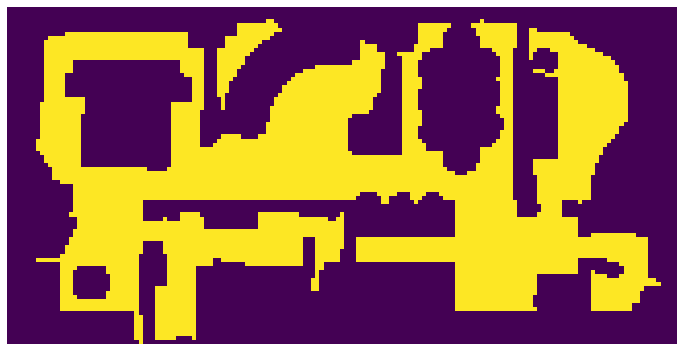

Displaying the map from the Habitat-Lab maps module:


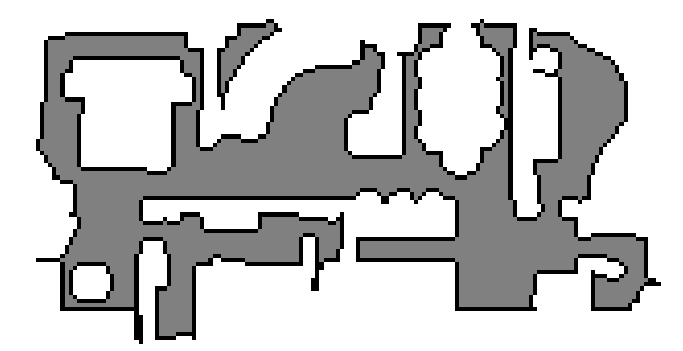

In [ ]:
# convert 3d points to 2d topdown coordinates
def convert_points_to_topdown(pathfinder, point, meters_per_pixel):
    points_topdown = []
    bounds = pathfinder.get_bounds()
    #for point in points:
        # convert 3D x,z to topdown x,y
    px = (point[0] - bounds[0][0]) / meters_per_pixel
    py = (point[2] - bounds[0][2]) / meters_per_pixel
    #points_topdown.append(np.array([px, py]))
    return np.array([px, py])


# display a topdown map with matplotlib
def display_map(topdown_map, key_points=None):
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(1, 1, 1)
    ax.axis("off")
    plt.imshow(topdown_map)
    # plot points on map
    if key_points is not None:
        for point in key_points:
            plt.plot(point[0], point[1], marker="o", markersize=10, alpha=0.8)
    plt.show(block=False)

meters_per_pixel = 0.1  
custom_height = False  
height = 1  

print("The NavMesh bounds are: " + str(sim.pathfinder.get_bounds()))
if not custom_height:
    # get bounding box minumum elevation for automatic height
    height = sim.pathfinder.get_bounds()[0][1]

if not sim.pathfinder.is_loaded:
    print("Pathfinder not initialized, aborting.")
else:

    sim_topdown_map = sim.pathfinder.get_topdown_view(meters_per_pixel, height)

    if display:
        hablab_topdown_map = maps.get_topdown_map(
            sim.pathfinder, height, meters_per_pixel=meters_per_pixel
        )
        recolor_map = np.array(
            [[255, 255, 255], [128, 128, 128], [0, 0, 0]], dtype=np.uint8
        )
        hablab_topdown_map = recolor_map[hablab_topdown_map]
        print("Displaying the raw map from get_topdown_view:")
        display_map(sim_topdown_map)
        print("Displaying the map from the Habitat-Lab maps module:")
        display_map(hablab_topdown_map)

        # easily save a map to file:
        map_filename = os.path.join(output_path, "top_down_map.png")
        imageio.imsave(map_filename, hablab_topdown_map)

## Dividing the map into four quadrants and creating landmarks 

### '0' - Empty space
### '1' - Boundaries
### '2' - Landmarks

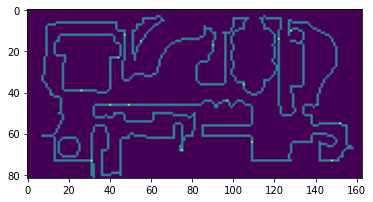

In [ ]:
newnewmap = np.zeros_like(hablab_topdown_map[:,:,0])
newnewmap[hablab_topdown_map[:,:,0]==0] = 1

xmid = newnewmap.shape[0]//2
ymid = newnewmap.shape[1]//2

quad_1 = np.argwhere(newnewmap[:xmid,:ymid] == 1)
quad_2 = np.argwhere(newnewmap[:xmid,ymid:] == 1)
quad_3 = np.argwhere(newnewmap[xmid:,:ymid] == 1)
quad_4 = np.argwhere(newnewmap[xmid:,ymid:] == 1)

rand_quad_1 = quad_1[np.random.randint(0,quad_1.shape[0], size=4)]
rand_quad_2 = quad_2[np.random.randint(0,quad_2.shape[0], size=4)]
rand_quad_3 = quad_3[np.random.randint(0,quad_3.shape[0], size=4)]
rand_quad_4 = quad_4[np.random.randint(0,quad_4.shape[0], size=4)]

for i in range(4):
  newnewmap[rand_quad_1[i][0], rand_quad_1[i][1]] = 2
  newnewmap[rand_quad_2[i][0], rand_quad_2[i][1] + ymid] = 2
  newnewmap[rand_quad_3[i][0] + xmid, rand_quad_3[i][1]] = 2
  newnewmap[rand_quad_4[i][0] + xmid, rand_quad_4[i][1] + ymid] = 2

plt.imshow(newnewmap)

beacons = np.argwhere(newnewmap==2)

## Generating trajectories for training and validation

In [ ]:
from habitat_sim.utils.common import quat_to_coeffs
from tqdm import tqdm

action_names = list(cfg.agents[sim_settings["default_agent"]].action_space.keys())

#Habitat gives the quaternion of the agent. We convert and return yaw for the 2D map
def euler_angles(quat):
    q = quat_to_coeffs(quat)[[3,0,1,2]]
    psi = math.atan2(2*(q[0]*q[3]+q[1]*q[2]), \
            1 - 2*(q[2]**2 + q[3]**2))
    return psi

def distance(x1, y1, x2, y2):
  return math.sqrt((x1-x2)**2 + (y1-y1)**2)

#Calculate distance from agent the five landmarks
def distance_to_beacons(curr_pos):
  distances = []
  for beacon in beacons:
    d = distance(beacon[0], beacon[1], curr_pos[0], curr_pos[1])
    distances.append(d)
  return sorted(distances)[:5]

#Generate data with random actions
def gen_data(num_trajs, max_frames = 80):
  trajectories = []
  actlist = []
  for _ in tqdm(range(num_trajs)):
    total_frames = 0
    traj = np.zeros((max_frames,11))
    while total_frames < max_frames:
        action = random.choice(action_names)
        actlist.append(action)
        old_agent_state = agent.get_state()
        old_yaw = euler_angles(old_agent_state.rotation)
        observations = sim.step(action)
        agent_state = agent.get_state()
        yaw = euler_angles(agent_state.rotation)
        xy_new = convert_points_to_topdown(
              sim.pathfinder, agent_state.position, meters_per_pixel)
        xy_old = convert_points_to_topdown(
              sim.pathfinder, old_agent_state.position, meters_per_pixel)
        act = xy_new - xy_old
        dist = distance_to_beacons(xy_new)
        traj[total_frames, :] = np.hstack((xy_new,np.array(yaw),act, np.array(yaw-old_yaw), np.array(dist)))
        total_frames += 1

    trajectories.append(traj)
    
  return dict(trajs=trajectories, map=newnewmap), actlist

In [ ]:
num_trajs_train = 10000
num_trajs_val = 500
train_data, train_actlist = gen_data(num_trajs_train)
val_data, val_actlist = gen_data(num_trajs_val)
import csv

100%|██████████| 500/500 [01:10<00:00,  7.11it/s]


### Saving the actions to a CSV file and generated trajectories to an NPY file


In [ ]:
l1 = []
with open('train_act.csv', 'w') as w:
  writer = csv.writer(w)
  for i, line in enumerate(train_actlist):
      l1.append(line)
      if (i+1)%80==0:
        writer.writerow(l1)
        l1.clear()
l2=[]
with open('val_act.csv', 'w') as w:
  writer = csv.writer(w)
  for i, line in enumerate(val_actlist):
      l2.append(line)
      if (i+1)%80==0:
        writer.writerow(l2)
        l2.clear()

In [ ]:
np.save('train_data.npy', train_data)
np.save('val_data.npy', val_data)

### Plotting a generated trajectory

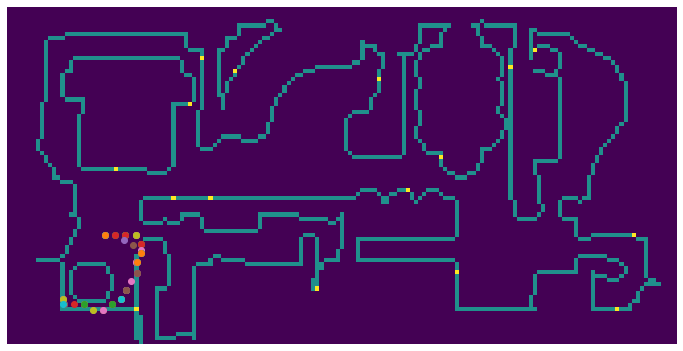

In [ ]:
plt.figure(figsize=(12, 8))
ax = plt.subplot(1, 1, 1)
ax.axis("off")
plt.imshow(train_data['map']) 
for point in train_data['trajs'][40]:
    plt.plot(point[0], point[1], marker='o')